In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

import os
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '/content/drive/MyDrive/Boots vs Shoes vs Sandal'
filepath = []
labels = []

folds = os.listdir(data_path)

for fold in folds:
    foldpath = os.path.join(data_path , fold)
    files = os.listdir(foldpath)

    for file in files :

        file_path = os.path.join(foldpath , file)
        filepath.append(file_path)
        labels.append(fold)

#concat data path with labels

fseries = pd.Series(filepath , name= 'filepath')
lseries = pd.Series(labels , name = 'labels')

df = pd.concat([fseries , lseries] , axis = 1)

df

,filepath,labels
0,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Sandal
1,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Sandal
2,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Sandal
3,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Sandal
4,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Sandal
...,...,...
12095,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Shoe
12096,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Shoe
12097,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Shoe
12098,/content/drive/MyDrive/Boots vs Shoes vs Sanda...,Shoe


In [11]:
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state = 42)
valid , test = train_test_split(df , test_size = 0.5 , shuffle = True , random_state = 42)
print("Train Shape",train.shape)
print("Valid Shape",valid.shape)
print("Test Shape",test.shape)

Train Shape (9680, 2)
Valid Shape (6050, 2)
Test Shape (6050, 2)


In [13]:
img_size = (224 , 224)
batches = 32


tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'filepath',y_col = "labels" , target_size = img_size ,color_mode = 'rgb',
                                       class_mode = 'categorical', shuffle = True , batch_size = batches)

test_gen = ts_gen.flow_from_dataframe(test , x_col = 'filepath' , y_col= 'labels' , target_size = img_size , color_mode= 'rgb',
                                     class_mode = 'categorical' , shuffle = False , batch_size = batches)

val_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepath' , y_col= 'labels',target_size = img_size ,color_mode = 'rgb',
                                    class_mode = 'categorical', shuffle = True , batch_size = batches)

Found 9680 validated image filenames belonging to 2 classes.
Found 6050 validated image filenames belonging to 2 classes.
Found 6050 validated image filenames belonging to 2 classes.


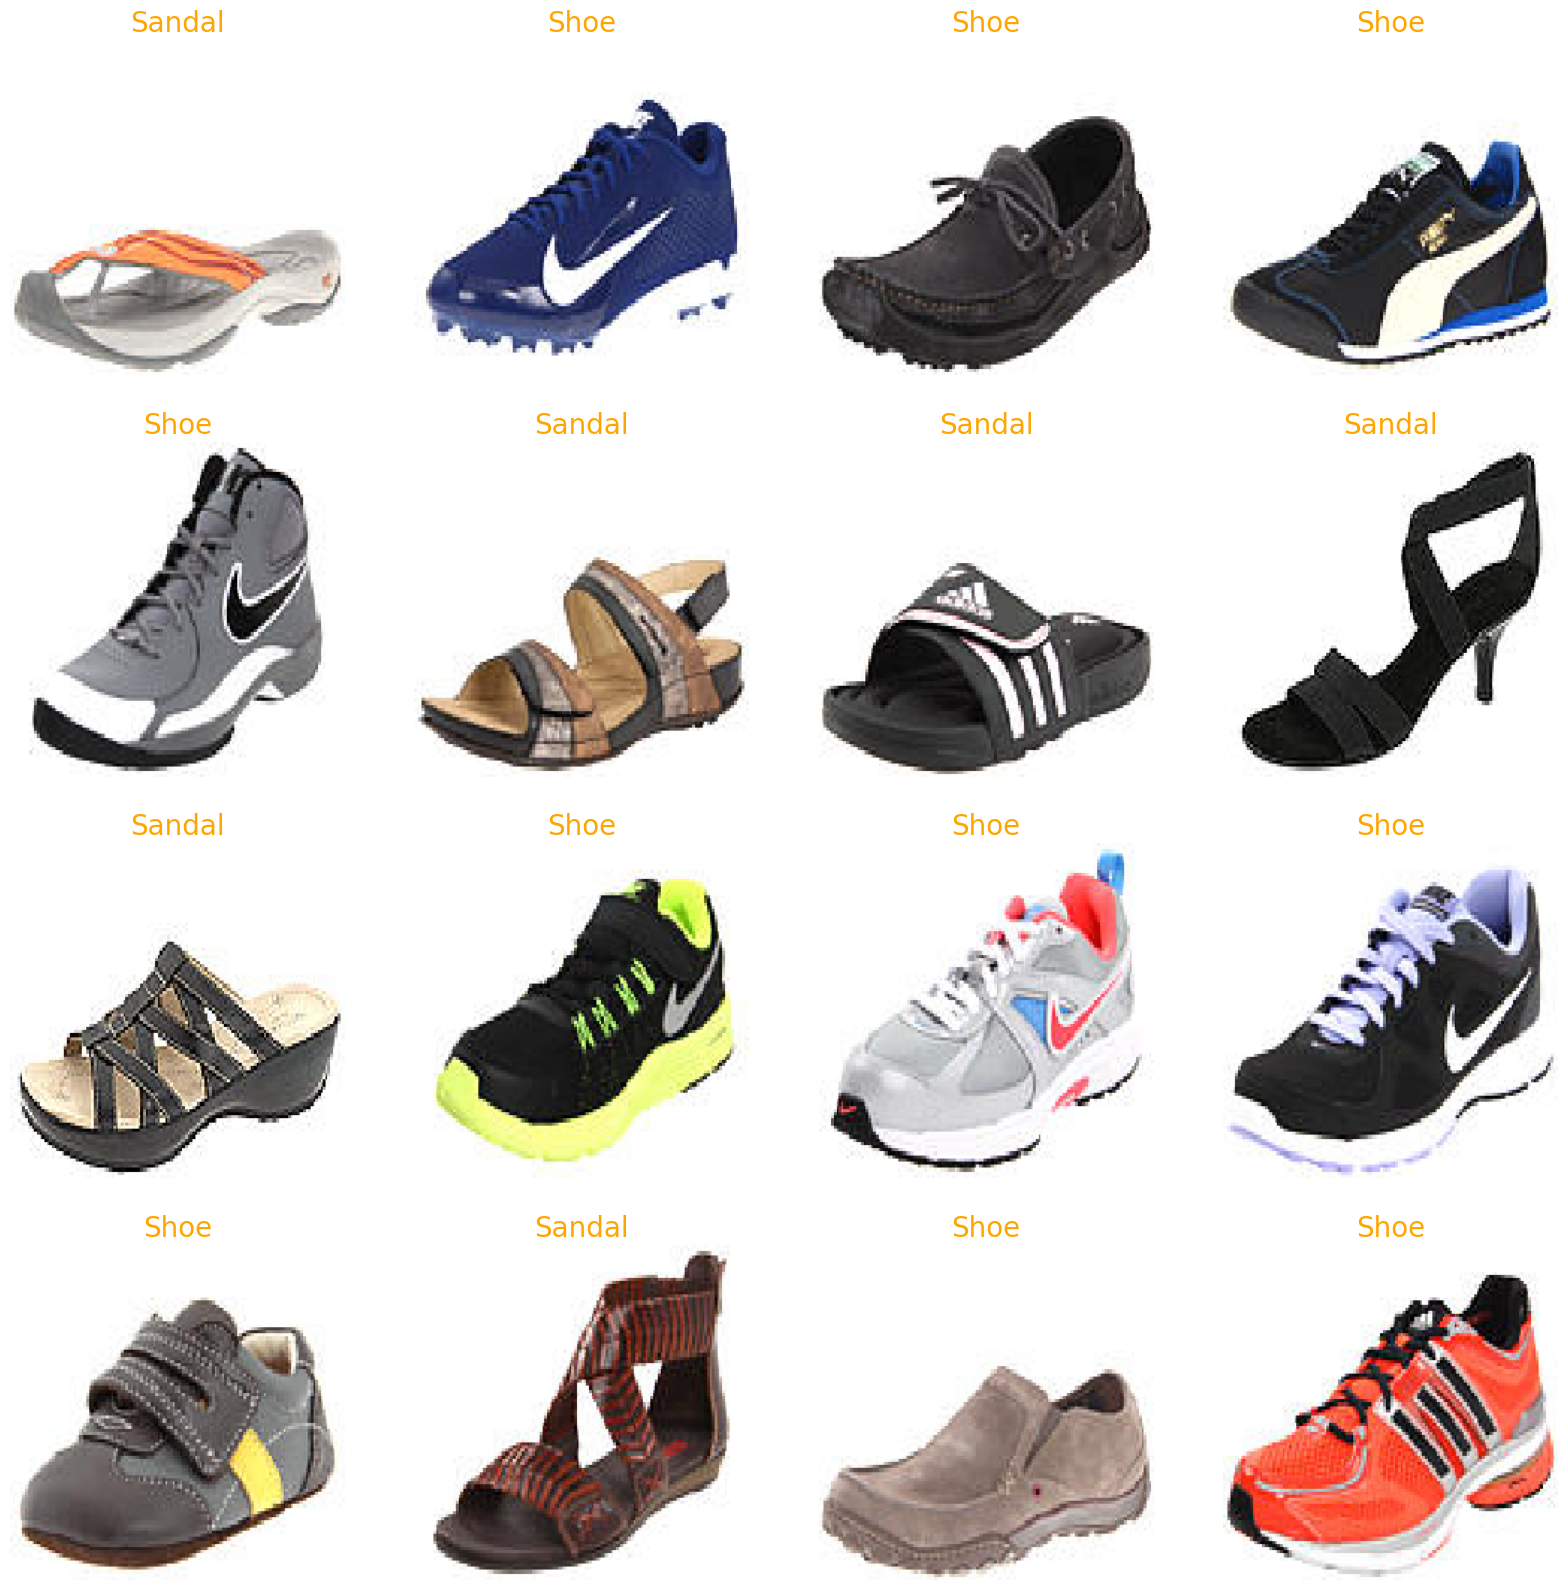

In [14]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())

images , labels = next(train_gen)

plt.figure(figsize = (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'orange', fontsize = 20)
    plt.axis('off')

plt.show();

In [15]:
#channels = 3
#img_shape = (img_size[0] , img_size[1] , channels)
img_shape = (224 , 224 , 3)
class_count = len(classes)

base_model = tf.keras.applications.ConvNeXtSmall(include_top = False , weights = 'imagenet' ,pooling = 'max', input_shape= img_shape )

#base_model = tf.keras.applications.ConvNeXtSmall(include_top=False, weights=None, pooling='max', input_shape=img_shape)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    #BatchNormalization(axis = -1,momentum=0.99,epsilon=0.001),
    Dense(256 , activation= 'relu'),
    Dense(class_count , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss= 'categorical_crossentropy' , metrics = ['accuracy'])
#model.summary()

In [7]:
print(class_count)

2


In [8]:
base_model.output.shape

(None, 768)

In [9]:
model.summary()

ValueError: Undefined shapes are not supported.

In [16]:
epochs = 1
his = model.fit(x= train_gen , validation_data= val_gen , epochs = epochs , validation_steps= None ,verbose= 1,
               shuffle = False)

303/303 ━━━━━━━━━━━━━━━━━━━━ 2109s 7s/step - accuracy: 0.9602 - loss: 0.0970 - val_accuracy: 0.9924 - val_loss: 0.0276


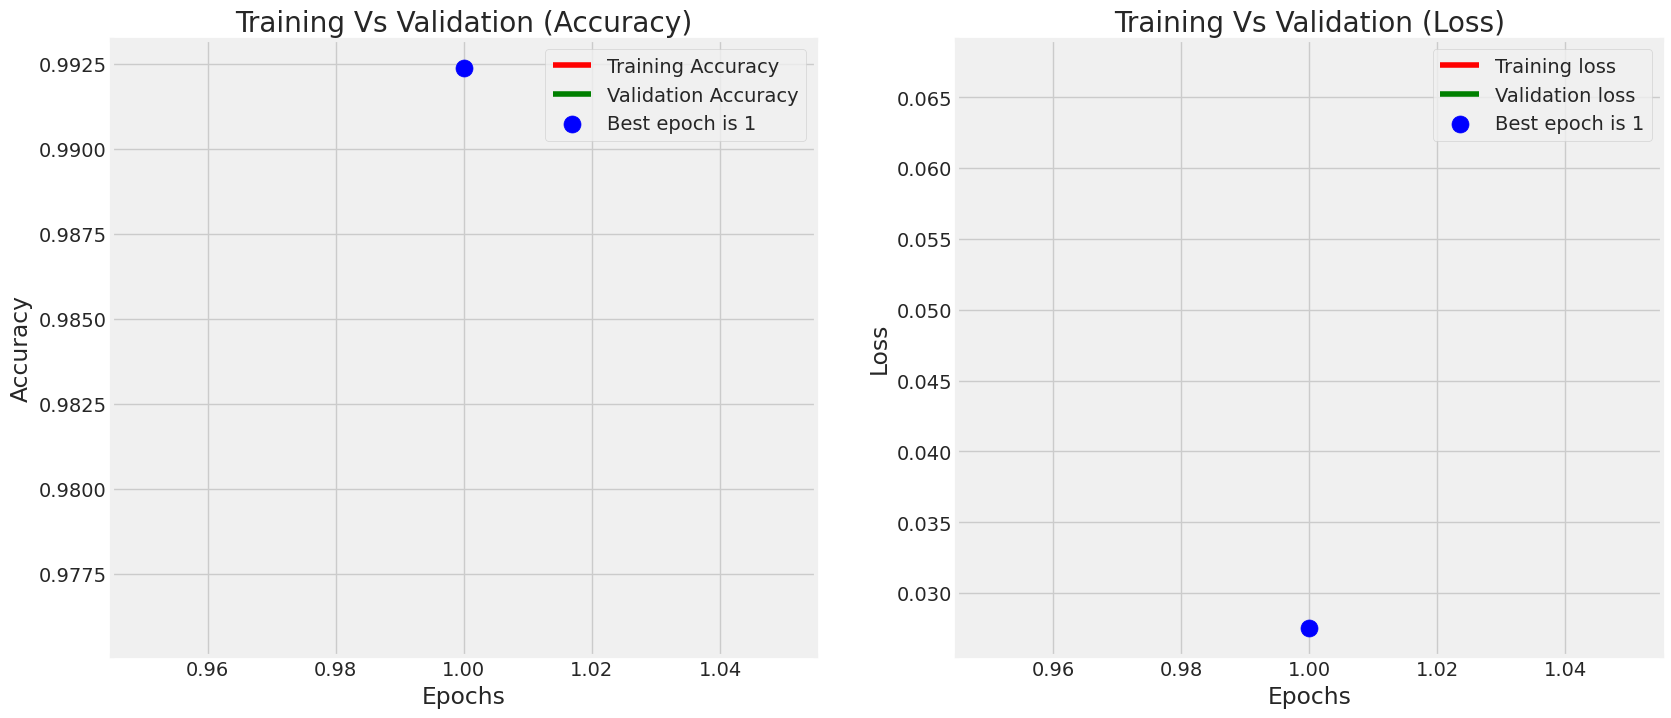

In [17]:
train_acc = his.history['accuracy']
train_loss = his.history['loss']

val_acc = his.history['val_accuracy']
val_loss = his.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label = "Training loss")
plt.plot(epochs , val_loss , 'g' , label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show()

In [18]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(val_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train Loss {train_score[0]} and Train Accuracy {train_score[1]}')
print(f'Validation Loss {valid_score[0]} and Validation Accuracy {valid_score[1]}')
print(f'Test Loss {test_score[0]} Test Accuracy {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.9909 - loss: 0.0361
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.9928 - loss: 0.0208
32/32 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.9885 - loss: 0.0355
Train Loss 0.027688926085829735 and Train Accuracy 0.9931640625
Validation Loss 0.01845477893948555 and Validation Accuracy 0.9951171875
Test Loss 0.043154276907444 Test Accuracy 0.9853515625


In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

190/190 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step


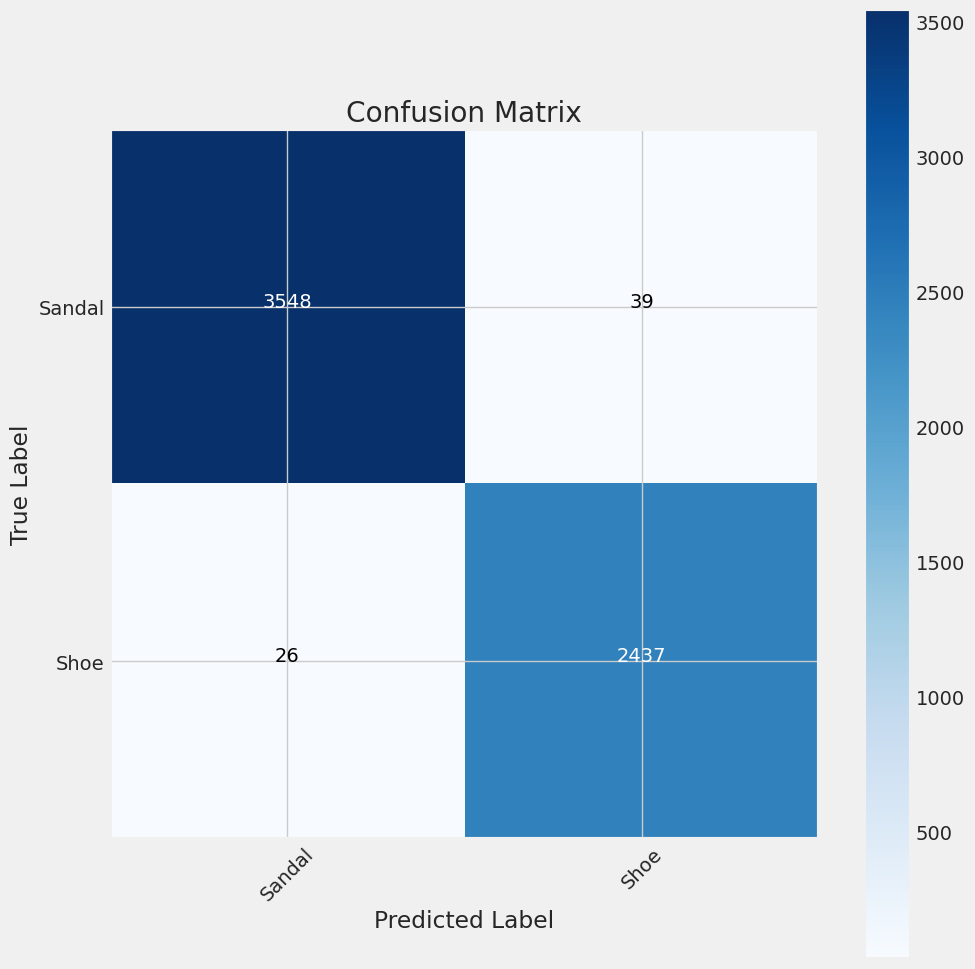

In [20]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [21]:
print(classification_report(test_gen.classes , y_pred , target_names = classes))

              precision    recall  f1-score   support

      Sandal       0.99      0.99      0.99      3587
        Shoe       0.98      0.99      0.99      2463

    accuracy                           0.99      6050
   macro avg       0.99      0.99      0.99      6050
weighted avg       0.99      0.99      0.99      6050

